# Markov Chains

In this script, we try to make a distinction between SBH and LBH. We will look at the frequency of function types and compare them between the books.

In [1]:
import glob, re, collections, operator, scipy.stats, sklearn.metrics
from itertools import chain
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from discreteMarkovChain import markovChain
from tf.fabric import Fabric

## Loading the data


See ETCBC data [here](https://etcbc.github.io/bhsa/features/hebrew/c/0_home.html)

In [2]:
TF = Fabric(locations='C:/Users/etien/Documents/github/bhsa/tf', modules='c', silent=True)

api = TF.load('''
              otype
              book chapter verse
              function domain
              typ pdp
              ''')

api.makeAvailableIn(globals())


  0.00s loading features ...
   |     0.05s B otype                from C:/Users/etien/Documents/github/bhsa/tf/c
   |     0.01s B book                 from C:/Users/etien/Documents/github/bhsa/tf/c
   |     0.00s B chapter              from C:/Users/etien/Documents/github/bhsa/tf/c
   |     0.01s B verse                from C:/Users/etien/Documents/github/bhsa/tf/c
   |     0.06s B function             from C:/Users/etien/Documents/github/bhsa/tf/c
   |     0.02s B domain               from C:/Users/etien/Documents/github/bhsa/tf/c
   |     0.19s B typ                  from C:/Users/etien/Documents/github/bhsa/tf/c
   |     0.11s B pdp                  from C:/Users/etien/Documents/github/bhsa/tf/c
   |     0.00s Feature overview: 108 for nodes; 5 for edges; 1 configs; 7 computed
  4.33s All features loaded/computed - for details use loadLog()


In [3]:
lbh_books = {'1_Chronicles', '2_Chronicles', 
             'Ezra', 'Esther', 'Nehemiah'}

sbh_books = {'Genesis', 'Exodus','Leviticus', 
             'Deuteronomy','Joshua', 'Judges', 
             '1_Kings', '2_Kings', '1_Samuel',
             '2_Samuel'}

# don't load clauses with these functions
exclude_functions = {'IntS', 'Ques', 'Exst', 'ModS',
                     'NCoS', 'NCop', 'Supp', 'PrAd',
                     'Frnt', 'Intj', 'EPPr', "ExsS", 
                     "PrcS", "Voct"}
#exclude_functions = set()
data = collections.defaultdict(list) # lbh, sbh, and individual books go in here
       
for i, clause in enumerate(F.otype.s('clause')):
    
    book, chapter, verse = T.sectionFromNode(clause)
    
    # skip clauses in our corpora
    if book not in (lbh_books | sbh_books):
        continue
    # skip non-narrative clauses
    if F.domain.v(clause) != 'N':
        continue
        
    clause_phrases = L.d(clause, otype='phrase')
    phrase_functions = [F.function.v(phrase) for phrase in clause_phrases]
    
    # skip if clause has excluded function
    if set(phrase_functions) & exclude_functions:
        continue
        
    if book in lbh_books:
        data['lbh'].append(phrase_functions)
    elif book in sbh_books:
        data['sbh'].append(phrase_functions)
        
    data[book].append(phrase_functions)
    
print(f'Done with {i} clauses loaded in data...')

Done with 88100 clauses loaded in data...


In [4]:
unique_functions = set(F.function.v(phrase) for phrase in F.otype.s('phrase') 
                           if F.function.v(phrase) not in exclude_functions)
unique_functions = sorted(list(unique_functions))
print(unique_functions)

['Adju', 'Cmpl', 'Conj', 'Loca', 'Modi', 'Nega', 'Objc', 'PreC', 'PreO', 'PreS', 'Pred', 'PtcO', 'Rela', 'Subj', 'Time']


 # Counting frequencies phrase functions

## Phrase function count

We can count the frequency of phrase functions. We consider three different approaches to count the functions. We can: 
1) Consider all phrase functions.
2) Consider only the first phrase function of a clause.
3) Consider only the last phrase function of a clause. 
Here, we do not yet look at the sequence of words, but only the frequency of phrase functions. 

In [5]:
phrase_function_count = dict() #Looking at all functions
begin_phrase_function_count = dict() #Consider only the first function of a clause
end_phrase_function_count = dict() #Consider only the last function of clause 

for bookname, clauses in data.items():
    phrase_function_count[bookname]=collections.Counter(list(chain(*clauses))) 
    begin_phrase_function_count[bookname]=collections.Counter([x[0] for x in clauses]) #First function
    end_phrase_function_count[bookname]=collections.Counter([x[-1] for x in clauses]) #Last function

#Make a dataframe
df_Count = pd.DataFrame(phrase_function_count,columns =data.keys()).fillna(0)
df_Begin_Count = pd.DataFrame(begin_phrase_function_count,columns =data.keys()).fillna(0)
df_End_Count = pd.DataFrame(begin_phrase_function_count,columns =data.keys()).fillna(0)

#Normalize the dataframes. This means that we divide all frequencies by the sum of the frequencies. 
df_prob_Count = df_Count.div(df_Count.sum(axis=0), axis=1)
df_prob_Begin_Count = df_Begin_Count.div(df_Begin_Count.sum(axis=0), axis=1)
df_prob_End_Count = df_End_Count.div(df_End_Count.sum(axis=0), axis=1)

In [6]:
#Sample
df_prob_Count[list(lbh_books)] #or sbh_books

,Nehemiah,1_Chronicles,2_Chronicles,Ezra,Esther
Adju,0.035974,0.062990,0.054427,0.074669,0.043700
Cmpl,0.122912,0.108207,0.124383,0.102079,0.150765
Conj,0.219700,0.216675,0.222932,0.174858,0.203933
Loca,0.022698,0.010455,0.013208,0.016068,0.008012
Modi,0.008137,0.006273,0.005660,0.006616,0.005827
Nega,0.014561,0.005227,0.010305,0.006616,0.007283
Objc,0.075375,0.085468,0.097678,0.093573,0.080845
PreC,0.091221,0.108468,0.061393,0.125709,0.061180
PreO,0.017131,0.015159,0.020464,0.008507,0.013110
PreS,0.001713,0.001045,0.004790,0.001890,0.002913


A second strategy to analyse clauses is looking at the length of these clauses.

## Length clauses count

In [7]:
length_count = dict()
for bookname, clauses in data.items():
    length_count[bookname]=collections.Counter([len(x) for x in clauses])
#Dataframe
df_length_count = pd.DataFrame(length_count,columns =data.keys()).fillna(0)
#Normalized
df_prob_length_count = df_length_count.div(df_length_count.sum(axis=0), axis=1)

# Graphing

Here, we can create graphs for analyzing the data.

## Comparing frequencies

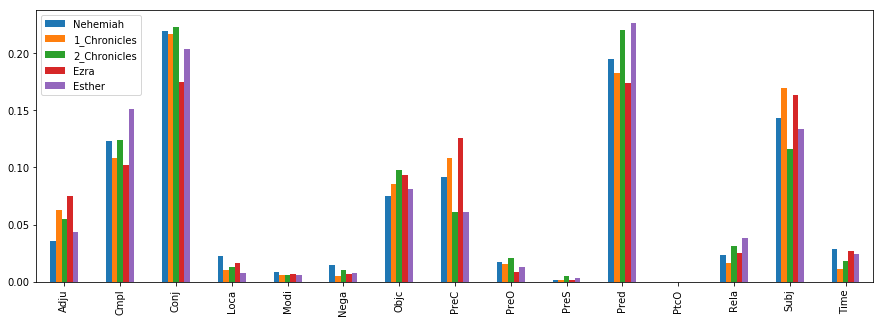

In [8]:
books = list(lbh_books) #["1_Samuel","2_Samuel"] #Choose two or more books to compare
df_graph = df_prob_Count[books] #or df_prob_Begin_Count, df_prob_length_count, df_prob_End_Count
plt.figure()
df_graph.plot(figsize = (15,5), kind='bar')
plt.show()

## Top frequent functions 

Here, a graph is made where the top most frequent functions is shown for each book. The x-axis shows the top x most frequent functions and the y-axis shows the probability that belongs to the top frequent functions. 

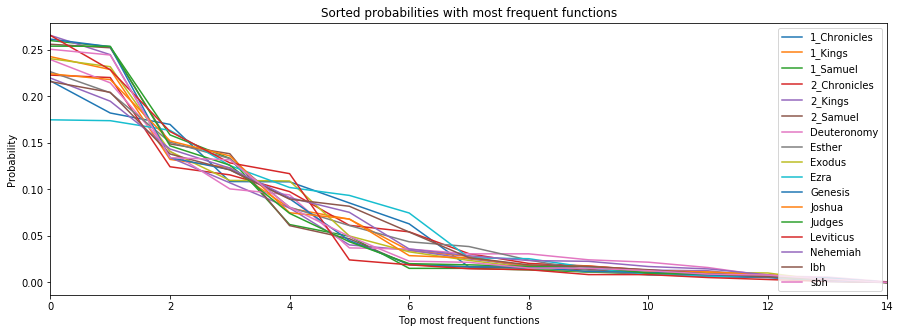

In [9]:
dictionary_prob = dict()
for column in df_prob_Count:
    probs = df_prob_Count[column].values
    dictionary_prob[column] = sorted(probs, reverse=True)
df_sorted_prob = pd.DataFrame(dictionary_prob)

plt.figure()
df_sorted_prob.plot(figsize = (15,5), kind='line')
plt.title("Sorted probabilities with most frequent functions")
plt.xlabel("Top most frequent functions")
plt.ylabel("Probability")
plt.show()

# Testing Frequencies

To compare books based on the function frequency, a chi-square test can be performed to look whether the frequencies are equivalent between books. We want to determine which books are the same and which are different. Normally, a p-value of 0.05 is used to determine whether the books are significant different. The null hypothesis in each test is that the books are equivalent based on the chosen criteria to compare the books. If the p-value is below 0.05, we reject the null hypothesis and therefore reject the hypothesis that the books show similarity based on the criteria. 

Here, we can perform a chi square test on any matrix and obtain the p value.

In [10]:
def chi_squareTest(matrix):
    chi2, p, dof, ex = scipy.stats.chi2_contingency(matrix)
    return p

The function computetesting performs the chi-square test on each pair of columns to look if two books are similar or different. 

In [11]:
def computetesting(df):
    books = df.keys()
    df_test= pd.DataFrame(np.zeros((len(books), len(books))), columns = books, index = books)
    for indexi,i in enumerate(books):
        for indexj,j in enumerate(books):
            if indexi>indexj:
                dfTemp = df[[i,j]]                     #Select columns
                dfTemp = dfTemp[(dfTemp.T != 0).any()] #Remove zeros
                dfTemp = np.matrix(dfTemp)             #Make np matrix
                dfTemp = dfTemp.transpose()            #Transpose matrix
                dfTemp = dfTemp.astype(int)            #Convert to integers
                df_test.loc[i,j] = round(chi_squareTest(dfTemp),5)
    
    return df_test.replace(0.0,np.nan)

For the dataframes: df_Count, df_Begin_Count, df_End_Count, df_length_count, the p values of the chi square testing can be obtained

In [12]:
computetesting(df_Begin_Count[list(sbh_books)])

,Judges,1_Kings,2_Kings,Joshua,Leviticus,2_Samuel,Genesis,1_Samuel,Deuteronomy,Exodus
Judges,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1_Kings,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2_Kings,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Joshua,NaN,0.00917,0.00019,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Leviticus,0.00095,0.00149,0.00005,0.00036,NaN,NaN,NaN,NaN,NaN,NaN
2_Samuel,0.39910,NaN,NaN,NaN,0.02270,NaN,NaN,NaN,NaN,NaN
Genesis,0.00062,NaN,NaN,NaN,0.00018,0.00239,NaN,NaN,NaN,NaN
1_Samuel,0.28865,NaN,NaN,NaN,0.00702,0.34363,NaN,NaN,NaN,NaN
Deuteronomy,NaN,NaN,NaN,NaN,0.00404,NaN,NaN,NaN,NaN,NaN
Exodus,NaN,NaN,NaN,NaN,0.00031,NaN,NaN,NaN,NaN,NaN


In [13]:
computetesting(df_Begin_Count[list(lbh_books)])

,Nehemiah,1_Chronicles,2_Chronicles,Ezra,Esther
Nehemiah,NaN,NaN,NaN,NaN,NaN
1_Chronicles,NaN,NaN,NaN,NaN,NaN
2_Chronicles,NaN,NaN,NaN,NaN,NaN
Ezra,NaN,NaN,NaN,NaN,NaN
Esther,NaN,NaN,0.01731,NaN,NaN


# Sequence phrase functions

The frequency analysis is now completed. Now, the order of the words can be looked into. First, we create a transition frequency table where we count the number of times we go from one phrase function to the next one. The Clause Begin can be seen as the state of the sequence before starting a new clause and Clause End indicates the state of the sequence after the last phrase function. We go obviously from the Clause End to Clause begin to show that we go to new clause. 

In [24]:
df_Transition_freq = dict() #Transition matrix with frequences
df_Transition_prob = dict() #Noramlized transition matrix

nodes = ["Clause_Begin", "Clause_End"] +  unique_functions

for bookname, clauses in data.items():
    transition_Matrix = np.zeros((len(nodes),len(nodes)))
    # count transitions using bigrams
    transitions = list()
    for clause in clauses:
        transitions.append("Clause_Begin")
        transitions.extend(clause)
        transitions.append("Clause_End")
    for i in range(0,len(transitions)-1):
        transition_Matrix[nodes.index(transitions[i]),nodes.index(transitions[i+1])] +=1 
    df_Trans = pd.DataFrame(transition_Matrix, columns = nodes, index = nodes)    
    
    #Remove unused transition functions
    df_Trans = df_Trans[(df_Trans.T != 0).any()]
    df_Trans = df_Trans.loc[:, (df_Trans != 0).any(axis=0)]
    
    df_Transition_freq[bookname] = df_Trans    
    #Normalized by row 
    df_Transition_prob[bookname] = df_Trans.div(df_Trans.sum(axis=1), axis=0)

#Sample
print(df_Transition_freq.keys())
df_Transition_freq["1_Samuel"] #df_Transition_prob


dict_keys(['sbh', 'Genesis', 'Exodus', 'Leviticus', 'Deuteronomy', 'Joshua', 'Judges', '1_Samuel', '2_Samuel', '1_Kings', '2_Kings', 'lbh', 'Esther', 'Ezra', 'Nehemiah', '1_Chronicles', '2_Chronicles'])


,Clause_Begin,Clause_End,Adju,Cmpl,Conj,Loca,Modi,Nega,Objc,PreC,PreO,PreS,Pred,Rela,Subj,Time
Clause_Begin,0.0,0.0,5.0,1.0,1732.0,0.0,2.0,2.0,4.0,41.0,21.0,18.0,155.0,87.0,39.0,1.0
Clause_End,2107.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Adju,0.0,58.0,4.0,5.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,2.0,0.0,1.0,0.0
Cmpl,0.0,704.0,15.0,38.0,0.0,16.0,6.0,2.0,30.0,6.0,0.0,0.0,5.0,0.0,49.0,18.0
Conj,0.0,0.0,2.0,9.0,1.0,5.0,0.0,43.0,20.0,29.0,70.0,1.0,1336.0,14.0,203.0,0.0
Loca,0.0,47.0,2.0,1.0,0.0,1.0,1.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,4.0,0.0
Modi,0.0,32.0,1.0,6.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,4.0,0.0,3.0,0.0
Nega,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,48.0,0.0,0.0,0.0
Objc,0.0,269.0,14.0,78.0,0.0,10.0,0.0,1.0,6.0,0.0,1.0,0.0,21.0,0.0,2.0,13.0
PreC,0.0,195.0,6.0,65.0,0.0,3.0,6.0,0.0,17.0,0.0,0.0,0.0,2.0,0.0,32.0,5.0


# Subtracting Transition Matrices

In [87]:
df_sub = df_Transition_prob["lbh"].subtract(df_Transition_prob["sbh"], fill_value =0)
round(df_sub,3)

,Clause_Begin,Clause_End,Adju,Cmpl,Conj,Loca,Modi,Nega,Objc,PreC,PreO,PreS,Pred,PtcO,Rela,Subj,Time
Clause_Begin,0.0,0.000,0.004,0.005,-0.100,0.001,-0.000,-0.003,-0.000,0.017,0.000,-0.002,0.015,-0.0,0.01,0.047,0.006
Clause_End,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.00,0.000,0.000
Adju,0.0,-0.098,0.027,0.013,0.000,0.001,-0.008,-0.001,0.039,0.003,0.001,0.000,-0.007,0.0,0.00,0.041,-0.010
Cmpl,0.0,-0.038,0.036,0.002,0.000,-0.011,-0.003,0.001,0.008,0.003,0.000,0.000,0.005,0.0,0.00,-0.007,0.006
Conj,0.0,0.000,0.022,0.011,-0.000,0.006,0.002,0.003,0.032,0.027,0.009,0.000,-0.178,0.0,0.00,0.054,0.013
Loca,0.0,-0.055,-0.007,-0.012,0.000,-0.027,0.002,-0.003,0.036,-0.011,0.005,0.000,0.084,0.0,0.00,-0.018,0.007
Modi,0.0,-0.124,0.009,0.028,0.008,-0.002,-0.002,0.001,0.032,0.030,-0.002,0.000,0.010,0.0,0.00,0.009,0.003
Nega,0.0,-0.002,0.020,0.005,0.000,0.000,0.000,0.000,0.000,0.011,0.003,0.000,-0.054,0.0,0.00,0.017,0.000
Objc,0.0,-0.010,0.050,-0.033,0.000,0.001,-0.001,0.003,-0.018,0.002,-0.000,0.000,0.016,0.0,0.00,-0.011,0.001
PreC,0.0,-0.007,0.034,-0.002,0.000,-0.016,-0.003,-0.000,0.023,0.000,0.000,0.000,-0.005,0.0,0.00,-0.019,-0.003


In [ ]:
df_sub_abs = abs(df_sub)
dictionary = dict()
for index, row_dict in enumerate(df_sub_abs.to_dict(orient="records")):
    for key, value in row_dict.items():
        dictionary[nodes[index],key]=value
sorted(dictionary.items(), key=operator.itemgetter(1), reverse=True)[:10]

In [ ]:
datadf = np.squeeze(np.asarray(df_sub.values)).ravel()
datadf = datadf[datadf!=0]
def reject_outliers(data, m=1):
    return data[abs(data - np.mean(data)) < m * np.std(data)]
datadf = reject_outliers(datadf)
plt.figure(figsize=(20,8))
plt.boxplot(datadf)
#plt.hist(datadf,bins=50)
plt.show()
#t.test(np.asmatrix(dfSubtracting))
scipy.stats.ttest_1samp(datadf, 0).pvalue
#scipy.stats.shapiro(datadf)

#scipy.stats.probplot(np.log(abs(datadf)), dist="norm", plot=plt)
#plt.show()
#scipy.stats.kstest(np.log(abs(datadf)), "lognorm", scipy.stats.lognorm.fit(datadf)



# Markov Chain

In [85]:
df_MC_SSP = pd.DataFrame()
for bookname,df in df_Transition_prob.items():
    P = np.matrix(df.as_matrix())
    mc = markovChain(P)
    mc.computePi('linear') #We can also use 'power', 'krylov' or 'eigen', 'linear'
    dfSS = pd.DataFrame(list(mc.pi), index=df.index, columns=[bookname])
    df_MC_SSP= pd.concat([dfSS,df_MC_SSP], axis=1)
df_MC_SSP= df_MC_SSP.sort_index(axis=1)
df_MC_SSP = df_MC_SSP.replace(np.nan,0.0)
df_MC_SSP

,1_Chronicles,1_Kings,1_Samuel,2_Chronicles,2_Kings,2_Samuel,Deuteronomy,Esther,Exodus,Ezra,Genesis,Joshua,Judges,Leviticus,Nehemiah,lbh,sbh
Adju,0.038097,0.016898,0.006893,0.033405,0.015293,0.011670,0.022542,0.026750,0.020229,0.043743,0.010065,0.016154,0.010395,0.011711,0.021489,0.032889,0.013200
Clause_Begin,0.197597,0.198149,0.193732,0.193123,0.197488,0.192721,0.196658,0.193937,0.192655,0.207087,0.195234,0.192716,0.192655,0.191282,0.201330,0.196550,0.194625
Clause_End,0.197597,0.198149,0.193732,0.193123,0.197488,0.192721,0.196658,0.193937,0.192655,0.207087,0.195234,0.192716,0.192655,0.191282,0.201330,0.196550,0.194625
Cmpl,0.065444,0.074432,0.081702,0.076341,0.081325,0.085038,0.085503,0.092287,0.067068,0.059801,0.073910,0.093524,0.090282,0.100195,0.073420,0.073422,0.080518
Conj,0.131046,0.138202,0.159268,0.136825,0.148167,0.157366,0.130198,0.124833,0.142565,0.102436,0.154490,0.137877,0.156045,0.141184,0.131236,0.131047,0.149346
Loca,0.006323,0.007644,0.005606,0.008106,0.008001,0.006124,0.009716,0.004904,0.014570,0.009413,0.007155,0.007794,0.006102,0.005205,0.013558,0.008310,0.007723
Modi,0.003794,0.004526,0.004503,0.003474,0.003545,0.005777,0.003498,0.003567,0.006261,0.003876,0.005032,0.005101,0.004181,0.005205,0.004861,0.003802,0.004800
Nega,0.003162,0.005733,0.005055,0.006325,0.007596,0.004391,0.013214,0.004458,0.006623,0.003876,0.002910,0.006943,0.005650,0.000651,0.008698,0.005566,0.005489
Objc,0.051691,0.048179,0.038140,0.059950,0.048410,0.037551,0.061018,0.049487,0.067429,0.054817,0.054872,0.046054,0.045650,0.072219,0.045024,0.054332,0.049414
PreC,0.065602,0.041038,0.030420,0.037680,0.024408,0.028885,0.018655,0.037450,0.030704,0.073643,0.027466,0.041944,0.026893,0.014964,0.054490,0.049706,0.030214


In [ ]:
sklearn.metrics.normalized_mutual_info_score(array2,array1)

## Verify MC SSP

We want to verify whether the MC SSP is the same as the normalized frequencies 

In [84]:
length = dict()
for bookname, clauses in data.items():
    length[bookname] = len(clauses) 
df_length = pd.DataFrame(length, index=["Clause_Begin","Clause_End"])
df_new = df_length.append(df_Count)
df_new = df_new.div(df_new.sum(axis=0), axis=1)
df_new= df_new.sort_index(axis=1)
df_new

,1_Chronicles,1_Kings,1_Samuel,2_Chronicles,2_Kings,2_Samuel,Deuteronomy,Esther,Exodus,Ezra,Genesis,Joshua,Judges,Leviticus,Nehemiah,lbh,sbh
Clause_Begin,0.197597,0.198149,0.193732,0.193123,0.197488,0.192721,0.196658,0.193937,0.192655,0.207087,0.195234,0.192716,0.192655,0.191282,0.201330,0.196550,0.194625
Clause_End,0.197597,0.198149,0.193732,0.193123,0.197488,0.192721,0.196658,0.193937,0.192655,0.207087,0.195234,0.192716,0.192655,0.191282,0.201330,0.196550,0.194625
Adju,0.038097,0.016898,0.006893,0.033405,0.015293,0.011670,0.022542,0.026750,0.020229,0.043743,0.010065,0.016154,0.010395,0.011711,0.021489,0.032889,0.013200
Cmpl,0.065444,0.074432,0.081702,0.076341,0.081325,0.085038,0.085503,0.092287,0.067068,0.059801,0.073910,0.093524,0.090282,0.100195,0.073420,0.073422,0.080518
Conj,0.131046,0.138202,0.159268,0.136825,0.148167,0.157366,0.130198,0.124833,0.142565,0.102436,0.154490,0.137877,0.156045,0.141184,0.131236,0.131047,0.149346
Loca,0.006323,0.007644,0.005606,0.008106,0.008001,0.006124,0.009716,0.004904,0.014570,0.009413,0.007155,0.007794,0.006102,0.005205,0.013558,0.008310,0.007723
Modi,0.003794,0.004526,0.004503,0.003474,0.003545,0.005777,0.003498,0.003567,0.006261,0.003876,0.005032,0.005101,0.004181,0.005205,0.004861,0.003802,0.004800
Nega,0.003162,0.005733,0.005055,0.006325,0.007596,0.004391,0.013214,0.004458,0.006623,0.003876,0.002910,0.006943,0.005650,0.000651,0.008698,0.005566,0.005489
Objc,0.051691,0.048179,0.038140,0.059950,0.048410,0.037551,0.061018,0.049487,0.067429,0.054817,0.054872,0.046054,0.045650,0.072219,0.045024,0.054332,0.049414
PreC,0.065602,0.041038,0.030420,0.037680,0.024408,0.028885,0.018655,0.037450,0.030704,0.073643,0.027466,0.041944,0.026893,0.014964,0.054490,0.049706,0.030214


## Information

Here the tendency of the Hebrew narrative verb to shape its clause environment really shows. That verb form, called the *wayyiqtol* ("vay-yiqtōl"), typically comprises a majority of the verb forms in narration. It does two things to the clause specifically, as confirmed by the data we see here:

1. Inserts a conjunction at the beginning of the clause ("And" or waw), which is inherent to the verb form itself. It is the "W" in the *wayyiqtol*. Note that the conjunction does not occur at clause-end in our sample.
2. Since this conjunction (waw) is inherent to the verb form and also because it connects the clause to the preceding clauses, there can be no intervening subjects between the conjunction and the core of the verb, e.g. W + Subject + core_yiqtol_verb.

The data confirms in Genesis these known tendencies about Biblical Hebrew narrative. The conjunction switches to the predicate in 83% of instances it is used in our sample. 

There are some interesting results. Complement elements (adverbs that give extra or necessary information) tend to occur at clause-end.

`Adju` -> `END` (66%), <br> 
`Cmpl` -> `END` (73%), <br>
`Loca`-> `END` (70%), <br>
`Modi` -> `END` (64%), <br>
`Time` -> `END` (73%).

The tendency for the `Time` function phrase observed in our sample is also discussed in the literature (1, 2).

These are the strong tendencies that we see here. But what about the smaller ratios? It may be that these more "movable" elements become even more important for our investigation into the change of the language through time. That would especially be so if we find that the broader tendencies of the two dated-sources are the same, but the subtle tendencies different.

# References

https://journal.r-project.org/archive/2011/RJ-2011-016/RJ-2011-016.pdf